# CEBRA

cebra is a method to use time information, to label behavior variables either 'near' or 'far', and use contrastive learning to train for an embedding.
the embedding will be a nice visualization of neural maniford, and provide the behavior variable mapping in neural (embedding) space.

# imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from pathlib import Path
import configparser
config = configparser.ConfigParser()
config.read_file(open('privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])
os.chdir(workdir)

In [18]:
# analysis
from scipy.io import loadmat
from sklearn.decomposition import FastICA
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.cross_decomposition import CCA
from cebra import CEBRA
import cebra

In [5]:
# misc
import pickle
from collections import defaultdict
from IPython.display import clear_output

In [6]:
from neural_plot_ult import *
import time
tic=time.time()
import warnings
warnings.filterwarnings('ignore')

# load neural and behavior data

In [7]:
df = pd.read_pickle(resdir/'m51df.pkl')
session=38

sessdf=df[df.session==session]
neural_data=np.concatenate(sessdf.PPC.to_numpy())
rawtaskvar=[np.concatenate(sessdf.belief_ff_hori.to_numpy()),
        np.concatenate(sessdf.eye_hori.to_numpy()),
        ]
# normalize to 0 mean 1 std
rawtaskvar=[np.array(normalize_z(y)) for y in rawtaskvar]
related_taskvar=np.vstack(rawtaskvar).T

# related_taskvar=np.clip(related_taskvar,-4,4)
mask=(related_taskvar > -4) & (related_taskvar < 4)
mask=(mask[:,0] & mask[:,1])
related_taskvar=related_taskvar[mask]
neural_data=neural_data[mask]

# init model and train

In [14]:
train_time = 3 # in minuts 
timesteps = neural_data.shape[0]
neurons = neural_data.shape[1]
out_dim = 3
max_iterations=train_time*10*60 # min, t/s, 60 sec 
time_offsets=4 # 0.1 s

single_cebra_model = CEBRA(model_architecture='offset10-model',
                        batch_size=2**13, # none for whole dataset
                        learning_rate=0.003,
                        temperature_mode="auto",
                        # temperature=1,
                        output_dimension=out_dim,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='mps',
                        verbose=True,
                        time_offsets=time_offsets)

# single_cebra_model.fit(neural_data, continuous_label[:,[0,2,4,6,12,]])
# embedding = single_cebra_model.transform(neural_data)
# assert(embedding.shape == (timesteps, out_dim))
# notify('cebra ready')

In [15]:
# training
single_cebra_model.fit(neural_data,related_taskvar)

pos: -2.3941 neg:  10.8952 total:  8.5012 temperature:  0.3177: 100%|██████████| 1800/1800 [02:50<00:00, 10.58it/s]


CEBRA(batch_size=8192, conditional='time_delta', device='mps',
      learning_rate=0.003, max_iterations=1800,
      model_architecture='offset10-model', output_dimension=3,
      temperature_mode='auto', time_offsets=4, verbose=True)

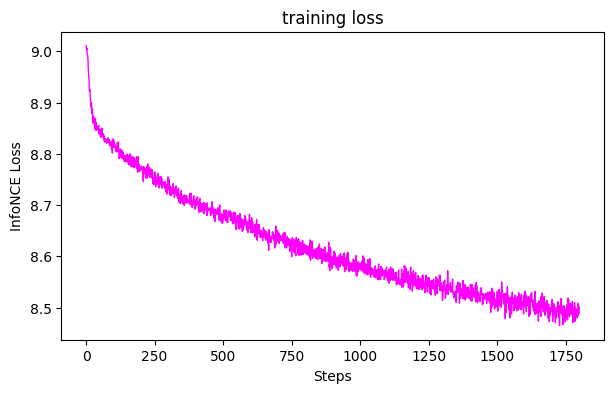

In [19]:
tmp_file = Path(f'{workdir}/test/neural/cebra/', f'{session}_{mytime()}.pt')
single_cebra_model.save(tmp_file)

notify(f'cebra {tmp_file} ready')

clear_output(wait=True)
ax=cebra.plot_loss(single_cebra_model)
ax.set_title('training loss')
plt.show()


# save and load

In [ ]:
# save and load

# tmp_file = Path(f'{workdir}/test/neural/cebra/', 'cebrafixeye_032920min.pt')
# single_cebra_model.save(tmp_file)


# # New session: load and use the model
print(tmp_file.name)
single_cebra_model = cebra.CEBRA.load(f'{workdir}/test/neural/cebra/{tmp_file.name}')


0404normzica_0405.pt


# analysis

thinking:
    the trained embedding shows a contrast low high value region for the task variables. including eye and belief.
    our goal is to better understand eye and belief. which part of them are simlar, which part are different.
    looking at the embedding, they show slightly different polar. in other words, they are 'shifted'. 
    if we think about this shift in vector or direction, they share a common direction (they project on that direction) and have distinct othognal component (thats the part they differ).
    if we can map the colorbar on to the embedding, or summarize the embedding sphere with a path, we can compare the path to see the difference. but still, we dont know what is a shared part path, what is individual compomnent path. (even that, could be a nice thing to plot)

plot: embedding in 3d
    its a sphere. we found some c shape structure emerge in training. this is expected.
    
plot: embedding diff in 3d
    we can color the scatter by diff of two variables. belief - eye. 
    but the unit are different. eg, belief heading cannnot be compared to eye directly. we can do 
    and hard to understand whats going on.
    res: seems there is some structure or pattern.

plot: embedding in 2d.
    similar results.

plot: embedding in 2d, connected by time
    this is a trial in embedding space. for smoother changing variables, eg, heading angle, this should be relatively smooth.
    res, somewhat smooth.


In [20]:
embedding = single_cebra_model.transform(neural_data)

## 3d embedding

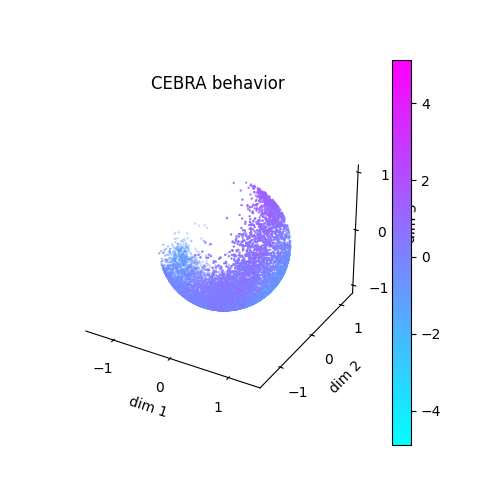

In [22]:
%matplotlib widget

fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(111, projection='3d')
ax1=plot_embedding_contrast(ax1, embedding, related_taskvar, beh_idx=[0,1])


ax1.set_title(f'CEBRA behavior')

plt.show()

## 2d embedding

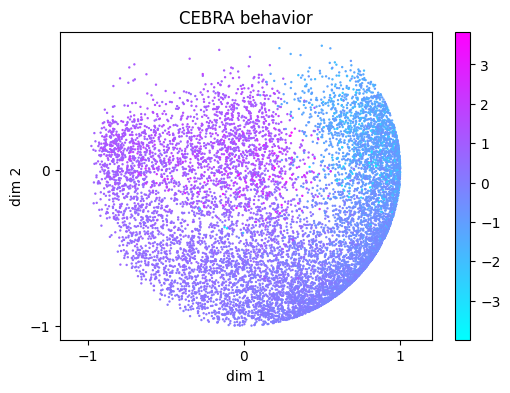

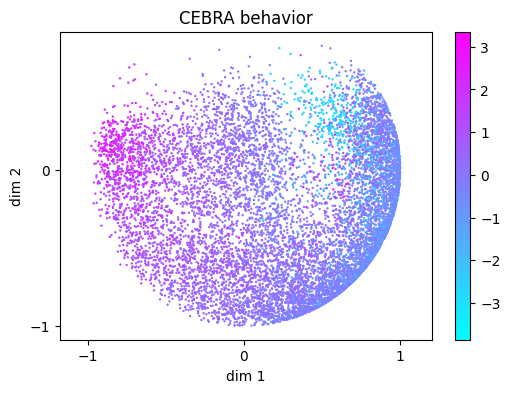

In [26]:
%matplotlib inline

for beh_idx in [0,1]:
    fig = plt.figure(figsize=(6,4))
    ax1 = plt.subplot(111)
    ax1=plot_embedding2d(ax1, embedding, related_taskvar, beh_idx=beh_idx)
    ax1.set_title(f'CEBRA behavior')
    plt.show()

## 2d embedding, trajectory

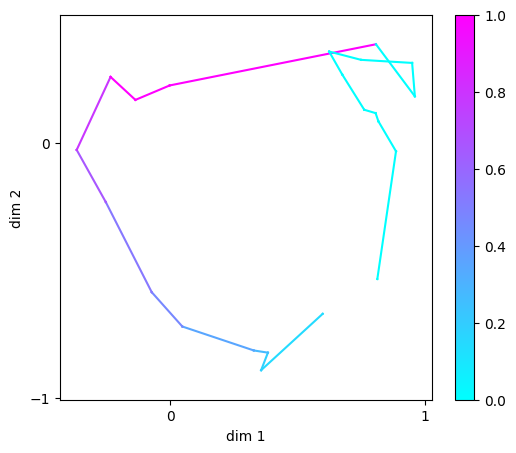

In [45]:
# a trajectory (connect time) in latent space
def plot_embedding2d_traj(ax, embedding, label, gray = False, beh_idx=0, idx_order = (0,1)):
    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx]
    else:
        r_cmap = None
        r_c = 'gray'
    
    idx1, idx2 = idx_order
    r=ax.scatter(embedding [:,idx1],
               embedding [:,idx2],
               c=r_c,
               vmin=0,
               vmax=1,
               cmap=r_cmap, s=0.5)
    x,y=embedding [:,idx1],embedding [:,idx2]
    for i in range(len(x) - 1):
        ax.plot([x[i], x[i+1]], [y[i], y[i+1]], c=plt.cm.cool(r_c[i]))
    plt.colorbar(r)
    ax.grid(False)
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.axis('equal')
    return ax


beh_idx=0
%matplotlib inline
fig = plt.figure(figsize=(6,5))
ax1 = plt.subplot(111)
t=np.random.randint(0, len(embedding))
ax1=plot_embedding2d_traj(ax1, embedding[t:t+22], related_taskvar[t:t+22], beh_idx=beh_idx)
# ax1.set_title(f'CEBRA behavior, {thisyname[beh_idx]}')


## plot: 2d embedding contrast



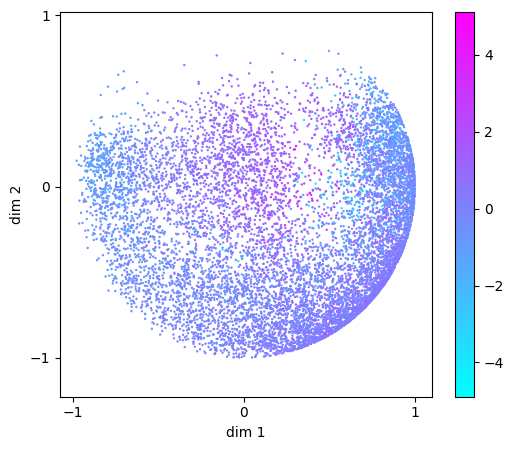

In [46]:
def plot_embedding2d_contrast(ax, embedding, label, gray = False, beh_idx=(0,1), idx_order = (0,1,2)):
    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx[0]]-label[:, beh_idx[1]]
    else:
        r_cmap = None
        r_c = 'gray'
    idx1, idx2, idx3 = idx_order
    r=ax.scatter(embedding [:,idx1],
               embedding [:,idx2],
               c=r_c,
            #    vmin=0,
            #    vmax=1,
               cmap=r_cmap, s=0.5)
    plt.colorbar(r)
    ax.grid(False)
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.axis('equal')
    return ax


%matplotlib inline
var1, var2=0,1 # color using belief - eye
fig = plt.figure(figsize=(6,5))
ax1 = plt.subplot(111)
ax1=plot_embedding2d_contrast(ax1, embedding, related_taskvar, beh_idx=[var1, var2])
# ax1.set_title(f'CEBRA behavior, {thisyname[var1]}-{thisyname[var2]}')
plt.show()
